In [17]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter

# LOADING DATASET

In [18]:
data = pd.read_csv('train.csv')
print('Dataframe Shape:', data.shape)
data=data.drop('0',axis=1)
data.head()

Dataframe Shape: (78199, 786)


,ka,255,254,229,149,96,84,77,71,100,...,255.233,254.24,164.2,2.7,0.196,0.197,0.198,68.1,230.2,255.234
0,ka,255,255,255,255,255,255,255,255,255,...,39,223,255,255,255,255,238,234,255,255
1,ka,255,255,255,255,211,5,0,0,0,...,254,255,255,255,255,255,255,255,255,255
2,ka,255,255,255,255,255,255,254,254,255,...,255,255,255,255,255,255,255,255,255,255
3,ka,255,255,255,255,250,233,233,240,224,...,249,55,0,29,218,255,255,255,255,255
4,ka,250,217,172,149,171,124,84,66,55,...,255,255,255,255,255,255,255,255,255,255


In [19]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 78199
Number of pixels in each image: 784


In [20]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

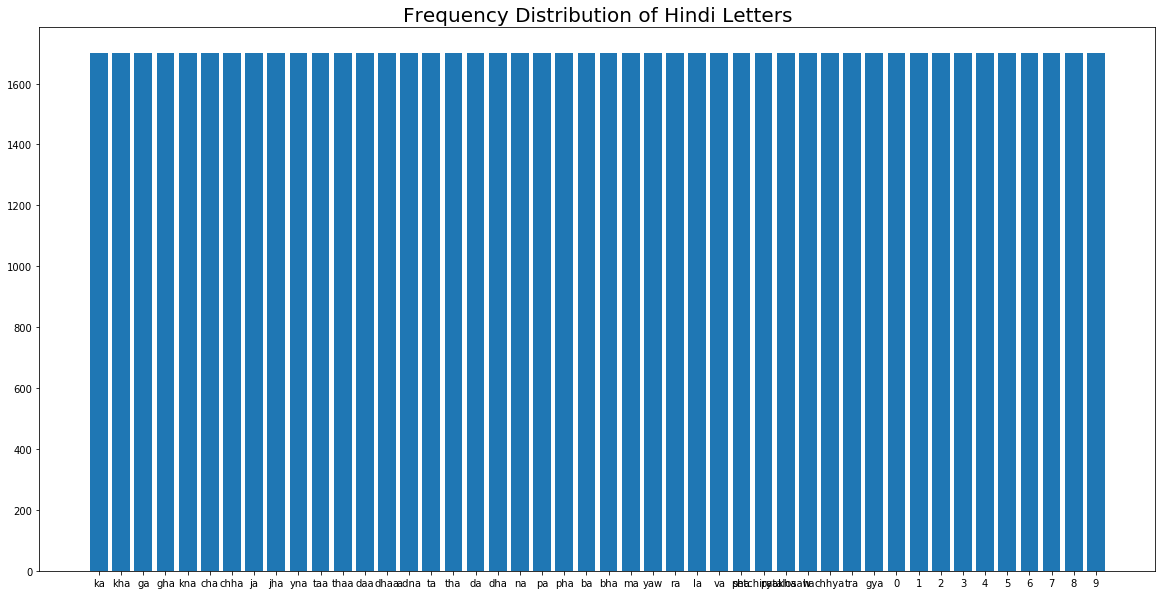

Labels:
 [0 0 0 ... 45 45 45]
Shape of Labels: (78199,)


In [21]:
y = data.iloc[:,:1].values.flatten()
for i in range(len(y)):
    if type(y[i]) is int:
        y[i]=str(y[i])
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Hindi Letters', fontsize = 20)
plt.show()
hindi_letters=['ka','kha','ga','gha','kna','cha','chha','ja','jha','yna','taa','thaa','daa','dhaa','adna','ta','tha','da','dha','na','pa','pha','ba','bha','ma','yaw','ra','la','va','sha','petchiryakha','patalosaw','ha','chhya','tra','gya','0','1','2','3','4','5','6','7','8','9']
for i in range(len(y)):
    y[i]=hindi_letters.index(y[i])
print('Labels:\n',y)
print('Shape of Labels:',y.shape)
for i in y:
    if type(i) is not int:
        print("HI")

In [22]:
from keras.utils import to_categorical

y_encoded = to_categorical(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (78199, 46)


In [23]:
learning_rate = 0.0005
epochs = 50
batch_size = 200
display_step = 100

In [24]:
n_input = 784
n_classes = 46
dropout = 0.5

In [25]:
# Placeholders
X = tf.placeholder(tf.float32, shape = [None,n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None,n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [26]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 46(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [27]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [28]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [29]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [30]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [31]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [33]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [34]:
init = tf.global_variables_initializer()

In [35]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (52393, 784)
y train shape (52393, 46)
X test shape (25806, 784)
y test shape (25806, 46)


In [36]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        keep_prob=0.0005*(1+0.0001*epochs)**0.75
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a float into a Tensor.